thanks https://www.kaggle.com/geekysaint , for the very clear guide on basic ML and pytorch concepts
https://www.kaggle.com/code/geekysaint/solving-mnist-using-pytorch

In [3]:
## Imports
import torch
import torchvision ## Contains some utilities for working with the image data
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
#%matplotlib inline
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F

## dataset analysis

In [7]:
data_dir = '../../../data/kaggle/'

In [8]:
dataset = MNIST(root = data_dir, download = True)
print(len(dataset))

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.67MB/s]


Extracting ../../../data/kaggle/MNIST/raw/train-images-idx3-ubyte.gz to ../../../data/kaggle/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 448kB/s]


Extracting ../../../data/kaggle/MNIST/raw/train-labels-idx1-ubyte.gz to ../../../data/kaggle/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.76MB/s]


Extracting ../../../data/kaggle/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../../data/kaggle/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.60MB/s]

Extracting ../../../data/kaggle/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../../data/kaggle/MNIST/raw

60000


Label: 9


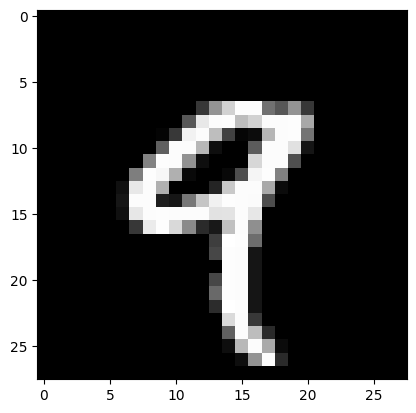

In [13]:
image, label = dataset[4]
plt.imshow(image, cmap = 'gray')
print('Label:', label)

In [14]:
## MNIST dataset(images and labels)
mnist_dataset = MNIST(root = data_dir, train = True, transform = transforms.ToTensor())
print(mnist_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../../../data/kaggle/
    Split: Train
    StandardTransform
Transform: ToTensor()


In [18]:
image_tensor, label = mnist_dataset[4]
print(image_tensor.shape, label)

torch.Size([1, 28, 28]) 9


In [19]:
# print tensor region from 10 to 15 in both dimensions
print(image_tensor[:,10:15,10:15])
print(torch.max(image_tensor), torch.min(image_tensor))

tensor([[[0.9882, 0.9882, 0.7176, 0.0549, 0.0000],
         [0.9882, 0.5725, 0.0549, 0.0000, 0.0000],
         [0.6902, 0.0353, 0.0000, 0.0000, 0.0314],
         [0.0000, 0.0000, 0.0000, 0.1412, 0.7882],
         [0.0863, 0.4667, 0.7725, 0.9451, 0.9922]]])
tensor(1.) tensor(0.)


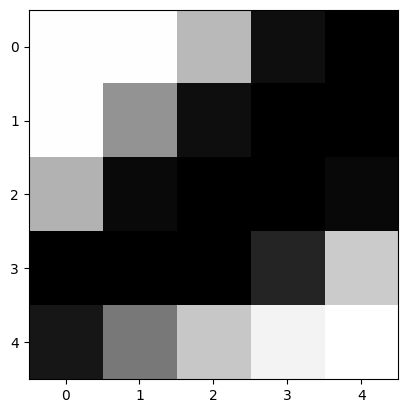

In [20]:
## Plot the image of the tensor
plt.imshow(image_tensor[0,10:15,10:15],cmap = 'gray')

## training and validation

In [21]:
train_data, validation_data = random_split(mnist_dataset, [50000, 10000])
## Print the length of train and validation datasets
print("length of Train Datasets: ", len(train_data))
print("length of Validation Datasets: ", len(validation_data))

length of Train Datasets:  50000
length of Validation Datasets:  10000


In [22]:
batch_size = 128
train_loader = DataLoader(train_data, batch_size, shuffle = True)
val_loader = DataLoader(validation_data, batch_size, shuffle = False)

## model

In [23]:
import torch.nn as nn

input_size = 28 * 28
num_classes = 10

## Logistic regression model
model = nn.Linear(input_size, num_classes)
print(model.weight.shape)
print(model.weight)
print(model.bias.shape)
print(model.bias)

torch.Size([10, 784])
Parameter containing:
tensor([[ 0.0316, -0.0335,  0.0103,  ..., -0.0194, -0.0055,  0.0032],
        [-0.0063,  0.0274, -0.0032,  ...,  0.0224, -0.0166,  0.0281],
        [-0.0187, -0.0217, -0.0320,  ...,  0.0051, -0.0076,  0.0081],
        ...,
        [-0.0274, -0.0215,  0.0270,  ...,  0.0017, -0.0139, -0.0328],
        [ 0.0088,  0.0156,  0.0308,  ...,  0.0063, -0.0012,  0.0158],
        [-0.0224,  0.0190,  0.0298,  ...,  0.0127,  0.0053,  0.0083]],
       requires_grad=True)
torch.Size([10])
Parameter containing:
tensor([-0.0221, -0.0273, -0.0187, -0.0099,  0.0230,  0.0109, -0.0239, -0.0036,
         0.0303, -0.0225], requires_grad=True)


In [36]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return(out)
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images) ## Generate predictions
        loss = F.cross_entropy(out, labels) ## Calculate the loss
        return(loss)
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return({'val_loss':loss, 'val_acc': acc})
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return({'val_loss': epoch_loss.item(), 'val_acc' : epoch_acc.item()})
    
    def epoch_end(self, epoch,result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
        
    
model = MnistModel()
print(model.linear.weight.shape, model.linear.bias.shape)

torch.Size([10, 784]) torch.Size([10])


In [29]:
for images, labels in train_loader:
    outputs = model(images)
    break
    
print('outputs shape: ', outputs.shape)
print('Sample outputs: \n', outputs[:2].data)

outputs shape:  torch.Size([128, 10])
Sample outputs: 
 tensor([[-0.1785, -0.0248,  0.0739, -0.0860,  0.0215, -0.0841, -0.1646, -0.1531,
          0.3629, -0.0141],
        [-0.1176,  0.2131,  0.0604, -0.0941,  0.1691, -0.0325, -0.0888, -0.1831,
          0.3255,  0.0164]])


## probabilistic normalization
### softmax
like logisitic regresion but for multiple exclusive classes
turns logits into probabilities by normalizing distances with exponential


In [31]:
## Apply softmax for each output row
probs = F.softmax(outputs, dim = 1)

## checking at sample probabilities
print("Sample probabilities:\n", probs[:2].data)

print("\n")
## Add up the probabilities of an output row
print("Sum: ", torch.sum(probs[0]).item())
max_probs, preds = torch.max(probs, dim = 1)
print("\n")
print(preds)
print("\n")
print(max_probs)

Sample probabilities:
 tensor([[0.0847, 0.0988, 0.1090, 0.0929, 0.1034, 0.0931, 0.0859, 0.0869, 0.1455,
         0.0998],
        [0.0855, 0.1190, 0.1021, 0.0875, 0.1139, 0.0931, 0.0880, 0.0801, 0.1332,
         0.0977]])


Sum:  0.9999998807907104


tensor([8, 8, 1, 8, 8, 1, 1, 8, 8, 8, 8, 1, 1, 4, 8, 8, 1, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 6, 8, 8, 0, 1, 8, 5, 1, 8, 2, 1, 1, 4, 8, 2, 4, 8, 9, 8, 8, 0,
        8, 8, 8, 1, 1, 8, 4, 2, 8, 1, 8, 8, 5, 8, 8, 0, 4, 8, 4, 1, 1, 8, 1, 1,
        1, 8, 8, 4, 1, 5, 1, 8, 8, 8, 8, 8, 8, 1, 1, 8, 0, 4, 6, 8, 8, 8, 5, 5,
        8, 8, 8, 8, 8, 1, 8, 8, 1, 5, 8, 8, 8, 8, 5, 4, 1, 8, 4, 4, 8, 1, 8, 1,
        8, 8, 1, 8, 8, 8, 8, 8])


tensor([0.1455, 0.1332, 0.1510, 0.1458, 0.1493, 0.1537, 0.1641, 0.1363, 0.1203,
        0.1344, 0.1323, 0.1353, 0.1194, 0.1395, 0.1449, 0.1730, 0.1222, 0.1439,
        0.1333, 0.1351, 0.1493, 0.1502, 0.1470, 0.1410, 0.1262, 0.1719, 0.1644,
        0.1170, 0.1439, 0.1489, 0.1375, 0.1520, 0.1364, 0.1428, 0.1547, 0.

In [34]:
print(len(labels))
labels

128


tensor([9, 2, 9, 4, 7, 5, 0, 2, 1, 4, 4, 2, 2, 8, 3, 3, 7, 8, 7, 8, 9, 5, 3, 8,
        5, 4, 8, 7, 9, 8, 7, 5, 3, 7, 0, 5, 5, 0, 3, 8, 4, 9, 3, 7, 2, 8, 4, 8,
        4, 3, 9, 2, 6, 9, 1, 9, 6, 2, 8, 9, 7, 9, 2, 7, 2, 8, 2, 3, 5, 9, 1, 0,
        4, 9, 6, 6, 0, 6, 1, 4, 1, 2, 4, 4, 8, 6, 5, 2, 0, 1, 5, 9, 2, 4, 2, 3,
        4, 1, 9, 3, 5, 2, 7, 2, 0, 6, 7, 2, 6, 3, 2, 1, 0, 2, 1, 1, 4, 3, 5, 6,
        9, 8, 6, 7, 5, 0, 7, 0])

## evaluation metric and loss function

In [35]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return(torch.tensor(torch.sum(preds == labels).item()/ len(preds)))

print("Accuracy: ",accuracy(outputs, labels))
print("\n")
loss_fn = F.cross_entropy
print("Loss Function: ",loss_fn)
print("\n")
## Loss for the current batch
loss = loss_fn(outputs, labels)
print(loss)

Accuracy:  tensor(0.1016)


Loss Function:  <function cross_entropy at 0x10d8fbba0>


tensor(2.3161, grad_fn=<NllLossBackward0>)


## training

In [37]:
def evaluate(model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return(model.validation_epoch_end(outputs))

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
      
    ## Training Phas
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    
    ## Validation phase
    result = evaluate(model, val_loader)
    model.epoch_end(epoch, result)
    history.append(result)
  return(history)

In [38]:
result0 = evaluate(model, val_loader)
result0

{'val_loss': 2.289623260498047, 'val_acc': 0.17375396192073822}

In [39]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9270, val_acc: 0.6416
Epoch [1], val_loss: 1.6625, val_acc: 0.7426
Epoch [2], val_loss: 1.4660, val_acc: 0.7726
Epoch [3], val_loss: 1.3176, val_acc: 0.7901
Epoch [4], val_loss: 1.2037, val_acc: 0.8021


In [40]:
history2 = fit(5, 0.001, model, train_loader, val_loader)


Epoch [0], val_loss: 1.1140, val_acc: 0.8098
Epoch [1], val_loss: 1.0420, val_acc: 0.8151
Epoch [2], val_loss: 0.9830, val_acc: 0.8201
Epoch [3], val_loss: 0.9339, val_acc: 0.8228
Epoch [4], val_loss: 0.8924, val_acc: 0.8261


In [41]:
history3 = fit(5, 0.001, model, train_loader, val_loader)


Epoch [0], val_loss: 0.8568, val_acc: 0.8301
Epoch [1], val_loss: 0.8259, val_acc: 0.8335
Epoch [2], val_loss: 0.7988, val_acc: 0.8351
Epoch [3], val_loss: 0.7750, val_acc: 0.8368
Epoch [4], val_loss: 0.7537, val_acc: 0.8393


In [42]:
history4 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7346, val_acc: 0.8400
Epoch [1], val_loss: 0.7173, val_acc: 0.8427
Epoch [2], val_loss: 0.7017, val_acc: 0.8435
Epoch [3], val_loss: 0.6874, val_acc: 0.8457
Epoch [4], val_loss: 0.6743, val_acc: 0.8468


Text(0.5, 1.0, 'Accuracy Vs. No. of epochs')

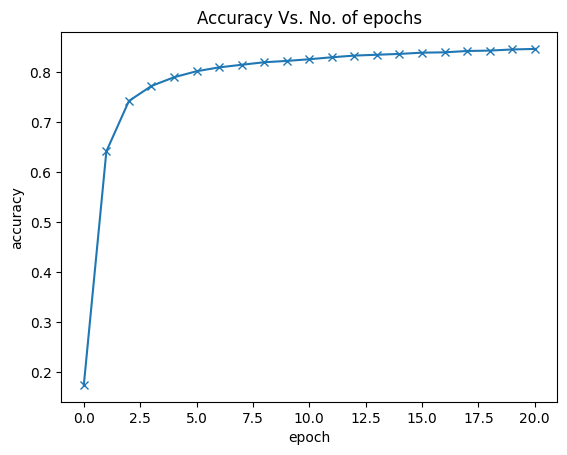

In [44]:
## Replace these values with your result
history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy Vs. No. of epochs')

## testing

In [46]:
## Define the test dataset
test_dataset = MNIST(root = data_dir, train = False, transform = transforms.ToTensor())

shape:  torch.Size([1, 28, 28])
Label:  7


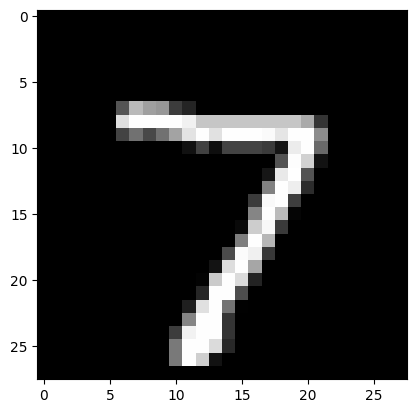

In [47]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap = 'gray')
print("shape: ", img.shape)
print('Label: ', label)

In [48]:
print(img.unsqueeze(0).shape)
print(img.shape)

torch.Size([1, 1, 28, 28])
torch.Size([1, 28, 28])


In [49]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim = 1)
    return(preds[0].item())

Label: 9 , Predicted : 9


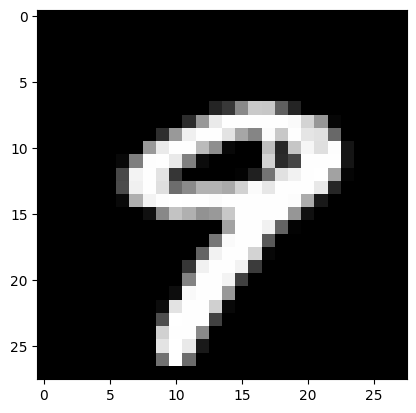

In [57]:
img, label = test_dataset[9]
plt.imshow(img[0], cmap = 'gray')
print('Label:', label, ', Predicted :', predict_image(img, model))

Label: 0 ,Predicted: 0


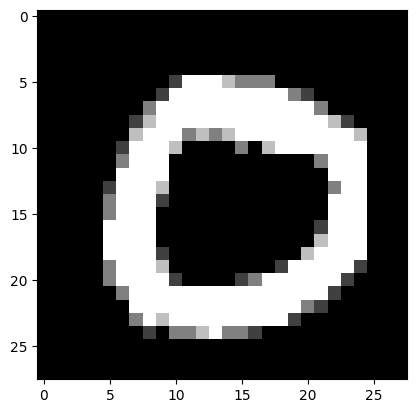

In [59]:
img, label = test_dataset[4999]
plt.imshow(img[0], cmap = 'gray')
print("Label:", label, ',Predicted:', predict_image(img, model))

## evaluate test dataset

In [60]:
test_loader = DataLoader(test_dataset, batch_size = 256)
result = evaluate(model, test_loader)
result

{'val_loss': 0.6390684843063354, 'val_acc': 0.8607422113418579}

## save and load model

In [61]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

In [62]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0068,  0.0070,  0.0077,  ..., -0.0037,  0.0083,  0.0239],
                      [ 0.0089, -0.0244,  0.0265,  ...,  0.0108,  0.0262, -0.0311],
                      [ 0.0283, -0.0251, -0.0356,  ...,  0.0145, -0.0044,  0.0027],
                      ...,
                      [-0.0267,  0.0246,  0.0351,  ...,  0.0021, -0.0138,  0.0025],
                      [ 0.0127,  0.0037,  0.0124,  ...,  0.0114, -0.0173,  0.0229],
                      [ 0.0126,  0.0045,  0.0099,  ..., -0.0090,  0.0229, -0.0218]])),
             ('linear.bias',
              tensor([-0.0325,  0.1251, -0.0534,  0.0014,  0.0429,  0.0219, -0.0423,  0.0070,
                      -0.0837, -0.0196]))])

In [63]:
model2 = MnistModel()
model2.load_state_dict(torch.load('mnist-logistic.pth'))
model2.state_dict()

/var/folders/s8/kl6fzfms2b7gvbxjt5t2wmr80000gn/T/ipykernel_1229/3052037875.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load('mnist-logis

OrderedDict([('linear.weight',
              tensor([[-0.0068,  0.0070,  0.0077,  ..., -0.0037,  0.0083,  0.0239],
                      [ 0.0089, -0.0244,  0.0265,  ...,  0.0108,  0.0262, -0.0311],
                      [ 0.0283, -0.0251, -0.0356,  ...,  0.0145, -0.0044,  0.0027],
                      ...,
                      [-0.0267,  0.0246,  0.0351,  ...,  0.0021, -0.0138,  0.0025],
                      [ 0.0127,  0.0037,  0.0124,  ...,  0.0114, -0.0173,  0.0229],
                      [ 0.0126,  0.0045,  0.0099,  ..., -0.0090,  0.0229, -0.0218]])),
             ('linear.bias',
              tensor([-0.0325,  0.1251, -0.0534,  0.0014,  0.0429,  0.0219, -0.0423,  0.0070,
                      -0.0837, -0.0196]))])

In [64]:
test_loader = DataLoader(test_dataset, batch_size = 256)
result = evaluate(model2, test_loader)
result

{'val_loss': 0.6390684843063354, 'val_acc': 0.8607422113418579}

## freestyle to improve accuracy

In [105]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [193]:
# import tuple
from typing import Any, Tuple
from PIL import Image

# Define Dataset class
class DigitDataset(MNIST):
    def __init__(self, root='./', labels=None, transform=None, train=True, data=None, download=False, targets=''):
        super().__init__(root, transform=transform, download=download, train=train)
        if data is not None:
            self.data = data
        if targets is not '':
            self.targets = targets
        # self.labels = torch.tensor(labels, dtype=torch.long) if labels is not None else None
        # self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        # print(self.data[index].shape)
        # Fetch the image
        if type(self.data[index]) == torch.Tensor:
            img = self.data[index].reshape(28, 28).numpy().astype('uint8')
        else:
            img = self.data[index].reshape(28, 28).astype('uint8')
        # print("type of img: ", type(img))
        # print(img.shape)

        # Convert to PIL Image for consistency
        img = Image.fromarray(img, mode="L")
        # img = Image.fromarray(img.numpy(), mode="L")

        # Apply transformations to the image
        if self.transform is not None:
            img = self.transform(img)

        # print(self.targets)
        # If targets exist, process and return them; otherwise, return only the image
        if self.targets is not None:
            target = int(self.targets[index])  # Convert target to int
            if self.target_transform is not None:
                target = self.target_transform(target)
            return img, target
        else:
            return img  # No label for test data
    


<>:11: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:11: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/var/folders/s8/kl6fzfms2b7gvbxjt5t2wmr80000gn/T/ipykernel_1229/2225246414.py:11: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if targets is not '':


In [81]:
# Define data augmentation and transforms
train_transform = transforms.Compose([
    transforms.RandomRotation(12),
    transforms.RandomAffine(0, translate=(0.15, 0.15), shear=15, scale=(0.85, 1.15)),
    transforms.ToTensor()
])

val_transform = transforms.ToTensor()

In [189]:
mnist_dataset = DigitDataset(root = data_dir, train = True, transform = train_transform)
print(mnist_dataset)

Dataset DigitDataset
    Number of datapoints: 60000
    Root location: ../../../data/kaggle/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-12.0, 12.0], interpolation=nearest, expand=False, fill=0)
               RandomAffine(degrees=[0.0, 0.0], translate=(0.15, 0.15), scale=(0.85, 1.15), shear=[-15.0, 15.0])
               ToTensor()
           )


In [190]:
print(len(mnist_dataset))
mnist_dataset[0][0].shape

60000
torch.Size([28, 28])
(28, 28)


torch.Size([1, 28, 28])

In [91]:
data_indices = list(range(len(mnist_dataset)))
labels = [mnist_dataset[i][1] for i in data_indices]  # Assuming mnist_dataset[i] returns (image, label)

# Perform train-test split
train_indices, val_indices = train_test_split(
    data_indices, 
    test_size=10000 / len(mnist_dataset),  # Equivalent to 10k validation samples from 60k
    random_state=42,  # For reproducibility
    stratify=labels  # Ensures balanced class distribution
)

# Create Subsets for train and validation datasets
train_data = Subset(mnist_dataset, train_indices)
validation_data = Subset(mnist_dataset, val_indices)

In [95]:
len(train_data), len(validation_data)

(50000, 10000)

In [98]:

class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        # CNN architecture
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),  # Input: 1x28x28, Output: 64x28x28
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # Output: 64x28x28
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),  # Output: 64x14x14
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Output: 128x14x14
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),  # Output: 128x14x14
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),  # Output: 128x7x7
            nn.Dropout(0.4),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # Output: 256x7x7
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),  # Output: 256x3x3
            nn.Dropout(0.4),
        )

        self.fc = nn.Sequential(
            nn.Flatten(),  # Flatten the tensor for dense layers
            nn.Linear(256 * 3 * 3, 512),  # Fully connected layer
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 10)  # Output layer for 10 classes
        )
    
    def forward(self, xb):
        # Pass through CNN layers
        xb = self.cnn(xb)
        # Pass through fully connected layers
        out = self.fc(xb)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate the loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

model = MnistModel()
for k in model.state_dict().keys():
    print(k, "\t", model.state_dict()[k].shape)

cnn.0.weight 	 torch.Size([64, 1, 3, 3])
cnn.0.bias 	 torch.Size([64])
cnn.1.weight 	 torch.Size([64])
cnn.1.bias 	 torch.Size([64])
cnn.1.running_mean 	 torch.Size([64])
cnn.1.running_var 	 torch.Size([64])
cnn.1.num_batches_tracked 	 torch.Size([])
cnn.3.weight 	 torch.Size([64, 64, 3, 3])
cnn.3.bias 	 torch.Size([64])
cnn.4.weight 	 torch.Size([64])
cnn.4.bias 	 torch.Size([64])
cnn.4.running_mean 	 torch.Size([64])
cnn.4.running_var 	 torch.Size([64])
cnn.4.num_batches_tracked 	 torch.Size([])
cnn.8.weight 	 torch.Size([128, 64, 3, 3])
cnn.8.bias 	 torch.Size([128])
cnn.9.weight 	 torch.Size([128])
cnn.9.bias 	 torch.Size([128])
cnn.9.running_mean 	 torch.Size([128])
cnn.9.running_var 	 torch.Size([128])
cnn.9.num_batches_tracked 	 torch.Size([])
cnn.11.weight 	 torch.Size([128, 128, 3, 3])
cnn.11.bias 	 torch.Size([128])
cnn.12.weight 	 torch.Size([128])
cnn.12.bias 	 torch.Size([128])
cnn.12.running_mean 	 torch.Size([128])
cnn.12.running_var 	 torch.Size([128])
cnn.12.num_batche

In [101]:
batch_size = 128
train_loader = DataLoader(train_data, batch_size, shuffle = True)
val_loader = DataLoader(validation_data, batch_size, shuffle = False)

In [102]:
result0 = evaluate(model, val_loader)
result0

{'val_loss': 2.3888158798217773, 'val_acc': 0.1028480976819992}

In [103]:
# simple training
histories = []
model = MnistModel()
for i in range(5):
    print(f"Training model {i+1}")
    # print loader
    history = fit(5, 0.001, model, train_loader, val_loader)
    histories.append(history)

accuracies = [result['val_acc'] for history in histories for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')

Training model 1
Epoch [0], val_loss: 2.1706, val_acc: 0.2292
Epoch [1], val_loss: 1.8643, val_acc: 0.3505
Epoch [2], val_loss: 1.5408, val_acc: 0.4675
Epoch [3], val_loss: 1.3348, val_acc: 0.5448
Epoch [4], val_loss: 1.1895, val_acc: 0.6024
Training model 2
Epoch [0], val_loss: 2.1969, val_acc: 0.2113


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), 'mnist-cnn-simple.pth')

In [106]:
# training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MnistModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3)

In [108]:
# Training loop
epochs = 20
best_val_loss = float('inf')
early_stop_counter = 0
patience = 5
print("Training on", device)
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    val_loss /= len(val_loader)
    train_loss /= len(train_loader)
    val_accuracy = correct / total

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "mnist-cnn.pth")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

# Load the best model for inference
model.load_state_dict(torch.load("mnist-cnn.pth"))
model.eval()


Training on cpu
Epoch 1/20
Epoch 1/20, Train Loss: 0.3192, Val Loss: 0.1380, Val Accuracy: 0.9594
Epoch 2/20
Epoch 2/20, Train Loss: 0.1548, Val Loss: 0.0880, Val Accuracy: 0.9742
Epoch 3/20
Epoch 3/20, Train Loss: 0.1187, Val Loss: 0.0777, Val Accuracy: 0.9760
Epoch 4/20
Epoch 4/20, Train Loss: 0.1045, Val Loss: 0.0632, Val Accuracy: 0.9822
Epoch 5/20
Epoch 5/20, Train Loss: 0.0962, Val Loss: 0.0678, Val Accuracy: 0.9813
Epoch 6/20
Epoch 6/20, Train Loss: 0.0890, Val Loss: 0.0558, Val Accuracy: 0.9848
Epoch 7/20
Epoch 7/20, Train Loss: 0.0831, Val Loss: 0.0529, Val Accuracy: 0.9835
Epoch 8/20
Epoch 8/20, Train Loss: 0.0770, Val Loss: 0.0465, Val Accuracy: 0.9868
Epoch 9/20
Epoch 9/20, Train Loss: 0.0716, Val Loss: 0.0588, Val Accuracy: 0.9828
Epoch 10/20
Epoch 10/20, Train Loss: 0.0749, Val Loss: 0.0464, Val Accuracy: 0.9860
Epoch 11/20
Epoch 11/20, Train Loss: 0.0658, Val Loss: 0.0549, Val Accuracy: 0.9848
Epoch 12/20
Epoch 12/20, Train Loss: 0.0633, Val Loss: 0.0453, Val Accuracy: 0

/var/folders/s8/kl6fzfms2b7gvbxjt5t2wmr80000gn/T/ipykernel_1229/410158533.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("mnist-cnn.pt

MnistModel(
  (cnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.3, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.01)
    (14): MaxPool2d(

In [ ]:
model = MnistModel()
# Load the best model for inference
model.load_state_dict(torch.load("mnist-cnn.pth"))
model.eval()

In [129]:
# def evaluate(model, val_loader):
#     outputs = []
#     for batch in val_loader:
#         X_batch = batch.to(device)  # Move images to the device
#         outputs.append(model.validation_step((X_batch, None)))  # Pass labels as None
#     return model.validation_epoch_end(outputs)

def evaluate(model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return(model.validation_epoch_end(outputs))


In [194]:
test_data_csv = pd.read_csv(data_dir + 'digit-recognizer/test.csv').values
test_dataset = DigitDataset(root = data_dir, train = False, transform = transforms.ToTensor(), download=False, data=test_data_csv, targets=None)
test_loader = DataLoader(test_dataset, batch_size = 256)
# result = evaluate(model, test_loader)
# result

In [198]:

# Prepare test predictions
predictions = []
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

# print
print(predictions)
print(len(predictions))

[2, 0, 9, 0, 3, 7, 0, 3, 0, 3, 5, 7, 4, 0, 4, 3, 3, 1, 9, 0, 9, 1, 1, 5, 7, 4, 2, 7, 4, 7, 7, 5, 4, 2, 6, 2, 5, 5, 1, 6, 7, 7, 4, 9, 8, 7, 8, 2, 6, 7, 6, 8, 8, 3, 8, 2, 1, 2, 2, 0, 4, 1, 7, 0, 0, 0, 1, 9, 0, 1, 6, 5, 8, 8, 2, 8, 9, 9, 2, 3, 5, 4, 1, 0, 9, 2, 4, 3, 6, 7, 2, 0, 6, 6, 1, 4, 3, 9, 7, 4, 0, 9, 2, 0, 7, 3, 0, 5, 0, 8, 0, 0, 4, 7, 1, 7, 1, 1, 3, 3, 3, 7, 2, 8, 6, 3, 8, 7, 7, 4, 3, 5, 6, 0, 0, 0, 3, 1, 3, 6, 4, 3, 4, 5, 5, 8, 7, 7, 2, 8, 4, 3, 5, 6, 5, 3, 7, 5, 7, 8, 3, 0, 4, 5, 1, 3, 7, 6, 3, 0, 2, 7, 8, 6, 1, 3, 7, 4, 1, 2, 4, 8, 5, 2, 4, 9, 2, 1, 6, 0, 6, 1, 4, 9, 6, 0, 9, 7, 6, 9, 1, 9, 0, 9, 9, 0, 8, 4, 6, 2, 0, 9, 3, 6, 3, 2, 1, 6, 3, 4, 2, 3, 1, 2, 2, 0, 4, 6, 1, 0, 0, 4, 9, 1, 7, 3, 2, 3, 8, 6, 8, 6, 2, 8, 5, 5, 4, 8, 3, 5, 9, 7, 1, 3, 8, 4, 5, 1, 4, 5, 6, 3, 3, 5, 7, 0, 6, 8, 3, 1, 6, 0, 6, 3, 9, 5, 1, 5, 8, 4, 0, 9, 2, 0, 5, 3, 7, 1, 9, 9, 5, 7, 7, 9, 9, 6, 3, 0, 3, 3, 6, 9, 8, 2, 6, 3, 7, 1, 4, 5, 8, 5, 9, 0, 0, 3, 8, 4, 1, 8, 4, 1, 1, 9, 8, 4, 5, 1, 5, 3, 6, 3, 1, 

In [197]:
import pandas as pd
# Save submission
submission = pd.DataFrame({'ImageId': range(1, len(predictions) + 1), 'Label': predictions})
submission.to_csv('./submission.csv', index=False)

print("Submission file saved as 'submission.csv'")

Submission file saved as 'submission.csv'
